In [1]:
from vae import BaseVAE, VAEConv2D, VolSurfaceDataSet, set_seeds, train, test
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
set_seeds(0)

In [3]:
class ConditionalVAEConv2D(BaseVAE):
    def __init__(self, seq_len, context_len,
                 feat_dim, latent_dim, device="cuda", kl_weight=1, 
                 hidden_layer_sizes=[100], ctx_hidden_layer_sizes=[100], ctx_embedding_size=100):
        '''
            Inputs:
                seq_len: the overall time sequence length
                context_len: the part of the sequence that should be treated as context, for now, we assume seq_len = context_len+1
                hidden_layer_sizes: the hidden layer sizes for the main encoder
                ctx_hidden_layer_sizes: the hidden layer sizes for the context encoder (for the convolutional hidden layers)
                ctx_embedding_size: the final embedding size of the context
        '''
        assert context_len + 1 == seq_len, "seq len > context_len + 1 is not supported"
        super().__init__(seq_len, feat_dim, latent_dim, device, kl_weight)
        self.context_len = context_len
        self.hidden_layer_sizes = hidden_layer_sizes
        self.ctx_hidden_layer_sizes = ctx_hidden_layer_sizes
        self.ctx_embedding_size = ctx_embedding_size

        # we want to keep the dimensions the same, out_dim = (in_dim - kernel_size + 2*padding) / stride + 1
        # so padding = (out_dim * stride + kernel_size - in_dim) // 2 where in_dim and out_dim are 5
        padding = ((feat_dim[-1] - 1) * 2 + 3 - feat_dim[-1]) // 2
        if ((feat_dim[-1] - 1) * 2 + 3 - feat_dim[-1]) % 2 == 1:
            padding1 = padding + 1
            deconv_output_padding = 1
        else:
            padding1 = padding
            deconv_output_padding = 0
        
        # encoder
        # encodes the context and current input, so total num of features = seq_len
        encoder_layers = OrderedDict()
        in_feats = self.seq_len
        for i, out_feats in enumerate(self.hidden_layer_sizes):
            
            encoder_layers[f"enc_conv_{i}"] = nn.Conv2d(
                in_feats, out_feats,
                kernel_size=3, stride=2, padding=padding1,
            )
            encoder_layers[f"enc_activation_{i}"] = nn.ReLU()
            in_feats = out_feats
        encoder_layers["flatten"] = nn.Flatten()
        self.encoder_conv = nn.Sequential(encoder_layers)
        self.z_mean_layer = nn.Linear(in_feats*feat_dim[0]*feat_dim[1], self.latent_dim)
        self.z_log_var_layer = nn.Linear(in_feats*feat_dim[0]*feat_dim[1], self.latent_dim)

        # context encoder
        # There is no need for distribution sampling
        ctx_encoder_layers = OrderedDict()
        in_feats = self.context_len
        for i, out_feats in enumerate(self.ctx_hidden_layer_sizes):
            ctx_encoder_layers[f"ctx_enc_conv_{i}"] = nn.Conv2d(
                in_feats, out_feats,
                kernel_size=3, stride=2, padding=padding1,
            )
            ctx_encoder_layers[f"ctx_enc_activation_{i}"] = nn.ReLU()
            in_feats = out_feats
        ctx_encoder_layers["flatten"] = nn.Flatten()
        ctx_encoder_layers["ctx_enc_final_linear"] = nn.Linear(in_feats*feat_dim[0]*feat_dim[1], self.ctx_embedding_size)
        self.ctx_encoder = nn.Sequential(ctx_encoder_layers)

        # decoder
        # Inputs: 
        #   1. the latents generated by main encoder on seq_len input
        #   2. the embedding generated by context encoder on context_len input
        # Firstly, we try to regenerate the final output of the main encoder using decoder_input layer
        # Then, the deconvolution will reconstruct the (Bxinput_lenx5x5) input, where input_len = seq_len-context_len 
        in_feats = self.hidden_layer_sizes[-1]
        self.decoder_input = nn.Linear(self.latent_dim + self.ctx_embedding_size, in_feats*feat_dim[0]*feat_dim[1])
        decoder_layers = OrderedDict()
        for i, out_feats in enumerate(reversed(self.hidden_layer_sizes[:-1])):
            decoder_layers[f"dec_deconv_{i}"] = nn.ConvTranspose2d(
                in_feats, out_feats,
                kernel_size=3, stride=2, padding=padding1, output_padding=deconv_output_padding,
                )
            decoder_layers[f"dec_activation_{i}"] = nn.ReLU()
            in_feats = out_feats
        
        # transform to the original size
        decoder_layers["dec_final"] = nn.ConvTranspose2d(
            in_feats, in_feats,
            kernel_size=3, stride=2, padding=padding1, output_padding=deconv_output_padding,
        )
        decoder_layers["dec_final_activation"] = nn.ReLU()
        decoder_layers["dec_output"] = nn.Conv2d(
            in_feats, self.seq_len - self.context_len,
            kernel_size=3, padding="same"
        )
        self.decoder_layers = nn.Sequential(decoder_layers)
        self.to(self.device)
    
    def encode(self, x):
        '''
            Input:
                x should be of shape BxTx5x5, 
                x[:,:context_len,:,:] are the context surfaces (previous days),
                x[:,context_len:,:,:] is the surface to predict
        '''
        x = self.encoder_conv(x) # Bx(hidden[-1]x5x5)
        z_mean = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)
        eps = torch.rand_like(z_log_var)
        z = z_mean + torch.exp(0.5 * z_log_var) * eps
        return (z_mean, z_log_var, z)
    
    def decode(self, x):
        '''
            Input:
                x should be of shape Bx(latent_dim+ctx_embedding_size)
        '''
        x = self.decoder_input(x) # Bx(hidden[-1]x5x5)
        x = x.view(-1, self.hidden_layer_sizes[-1], self.feat_dim[0], self.feat_dim[1])
        out = self.decoder_layers(x)
        return out

    def forward(self, x):
        '''
            Input:
                x should be either unbatched, (seq_len)x5x5 or batched Bx(seq_len)x5x5
        '''
        if len(x.shape) == 3 and x.shape[0] == self.seq_len:
            # unbatched data
            x = x.unsqueeze(0)
        ctx = x[:, :self.context_len, :, :] # c
        ctx_embedding = self.ctx_encoder(ctx) # embedded c
        z_mean, z_log_var, z = self.encode(x) # P(z|c,x)

        decoder_input = torch.cat([ctx_embedding, z], dim=1)
        reconstruction = self.decode(decoder_input) # P(x|c,z)
        return (reconstruction, z_mean, z_log_var, z)

    def train_step(self, x, optimizer: torch.optim.Optimizer):
        '''
            Input:
                x should be either unbatched, (seq_len)x5x5 or batched Bx(seq_len)x5x5
        '''
        if len(x.shape) == 3 and x.shape[0] == self.seq_len:
            # unbatched data
            x = x.unsqueeze(0)

        optimizer.zero_grad()
        x = x.to(self.device)
        input_x = x[:,self.context_len:, :, :] # x
        reconstruction, z_mean, z_log_var, z = self.forward(x)

        # RE = 1/M \sum_{i=1}^M (x_i - y_i)^2
        reconstruction_error = F.mse_loss(reconstruction, input_x)
        # KL = -1/2 \sum_{i=1}^M (1+log(\sigma_k^2) - \sigma_k^2 - \mu_k^2)
        kl_loss = -0.5 * (1 + z_log_var - torch.exp(z_log_var) - torch.square(z_mean))
        kl_loss = torch.mean(torch.sum(kl_loss, dim=1))
        total_loss = reconstruction_error + self.kl_weight * kl_loss
        total_loss.backward()
        optimizer.step()

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_error,
            "kl_loss": kl_loss,
        }
    
    def test_step(self, x):
        x = x.to(self.device)
        input_x = x[:,self.context_len:, :, :] # x
        reconstruction, z_mean, z_log_var, z = self.forward(x)

        # RE = 1/M \sum_{i=1}^M (x_i - y_i)^2
        reconstruction_error = F.mse_loss(reconstruction, input_x)
        # KL = -1/2 \sum_{i=1}^M (1+log(\sigma_k^2) - \sigma_k^2 - \mu_k^2)
        kl_loss = -0.5 * (1 + z_log_var - torch.exp(z_log_var) - torch.square(z_mean))
        kl_loss = torch.mean(torch.sum(kl_loss, dim=1))
        total_loss = reconstruction_error + self.kl_weight * kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_error,
            "kl_loss": kl_loss,
        }

In [4]:
data = np.load("data/vol_surface.npy")
print(data.shape)

(5532, 5, 5)


In [5]:
train_dataset = VolSurfaceDataSet(data[:4000], 1)
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=64)
valid_dataset = VolSurfaceDataSet(data[4000:5000], 1)
valid_dataloader = DataLoader(valid_dataset, shuffle=False, batch_size=16)
test_dataset = VolSurfaceDataSet(data[5000:], 1)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=16)

In [6]:
model_conv = VAEConv2D(1, (5, 5), 10, hidden_layer_sizes=[50, 100])
train(model_conv, train_dataloader, test_dataloader, epochs=2, model_dir="test", file_prefix="conv-50-100-2")

eval: 100%|██████████| 34/34 [00:00<00:00, 465.29it/s]


epoch 0: train loss :: 0.052, dev loss :: 0.098, time elapsed :: 1.9020276069641113


eval: 100%|██████████| 34/34 [00:00<00:00, 668.55it/s]

epoch 1: train loss :: 0.044, dev loss :: 0.088, time elapsed :: 0.4804983139038086
training finished, total time :: 2.38252592086792


In [7]:
test(model_conv, valid_dataloader, test_dataloader, model_dir="test", file_prefix="conv-50-100-2")

eval: 100%|██████████| 34/34 [00:00<00:00, 784.99it/s]

dev loss: 0.026, test_loss: 0.089


In [8]:
train_dataset = VolSurfaceDataSet(data[:4000], 2)
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=64)
valid_dataset = VolSurfaceDataSet(data[4000:5000], 2)
valid_dataloader = DataLoader(valid_dataset, shuffle=False, batch_size=16)
test_dataset = VolSurfaceDataSet(data[5000:], 2)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=16)

In [9]:
model = ConditionalVAEConv2D(2, 1, (5, 5), 10, hidden_layer_sizes=[50, 100], ctx_hidden_layer_sizes=[100], ctx_embedding_size=100)
print(model)

ConditionalVAEConv2D(
  (encoder_conv): Sequential(
    (enc_conv_0): Conv2d(2, 50, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (enc_activation_0): ReLU()
    (enc_conv_1): Conv2d(50, 100, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (enc_activation_1): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mean_layer): Linear(in_features=2500, out_features=10, bias=True)
  (z_log_var_layer): Linear(in_features=2500, out_features=10, bias=True)
  (ctx_encoder): Sequential(
    (ctx_enc_conv_0): Conv2d(1, 100, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (ctx_enc_activation_0): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (ctx_enc_final_linear): Linear(in_features=2500, out_features=100, bias=True)
  )
  (decoder_input): Linear(in_features=110, out_features=2500, bias=True)
  (decoder_layers): Sequential(
    (dec_deconv_0): ConvTranspose2d(100, 50, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
    (dec_activation_0): ReLU()
   

In [10]:
train(model, train_dataloader, valid_dataloader, epochs=20, model_dir="models/cvae", file_prefix="cvae-conv-50-100")

eval: 100%|██████████| 63/63 [00:00<00:00, 542.16it/s]


epoch 0: train loss :: 0.036, dev loss :: 0.022, time elapsed :: 0.7056446075439453


eval: 100%|██████████| 63/63 [00:00<00:00, 592.39it/s]


epoch 1: train loss :: 0.031, dev loss :: 0.018, time elapsed :: 0.6146619319915771


eval: 100%|██████████| 63/63 [00:00<00:00, 433.78it/s]


epoch 2: train loss :: 0.025, dev loss :: 0.012, time elapsed :: 0.6119241714477539


eval: 100%|██████████| 63/63 [00:00<00:00, 454.49it/s]


epoch 3: train loss :: 0.015, dev loss :: 0.008, time elapsed :: 0.691704273223877


eval: 100%|██████████| 63/63 [00:00<00:00, 492.82it/s]


epoch 4: train loss :: 0.009, dev loss :: 0.007, time elapsed :: 0.6602442264556885


eval: 100%|██████████| 63/63 [00:00<00:00, 446.01it/s]


epoch 5: train loss :: 0.008, dev loss :: 0.007, time elapsed :: 0.6871223449707031


eval: 100%|██████████| 63/63 [00:00<00:00, 483.43it/s]


epoch 6: train loss :: 0.008, dev loss :: 0.006, time elapsed :: 0.6881554126739502


eval: 100%|██████████| 63/63 [00:00<00:00, 441.91it/s]


epoch 7: train loss :: 0.008, dev loss :: 0.006, time elapsed :: 0.7314648628234863


eval: 100%|██████████| 63/63 [00:00<00:00, 493.05it/s]


epoch 8: train loss :: 0.008, dev loss :: 0.006, time elapsed :: 0.7288467884063721


eval: 100%|██████████| 63/63 [00:00<00:00, 450.45it/s]


epoch 9: train loss :: 0.008, dev loss :: 0.006, time elapsed :: 0.6922035217285156


eval: 100%|██████████| 63/63 [00:00<00:00, 489.37it/s]


epoch 10: train loss :: 0.008, dev loss :: 0.006, time elapsed :: 0.6941192150115967


eval: 100%|██████████| 63/63 [00:00<00:00, 485.90it/s]


epoch 11: train loss :: 0.007, dev loss :: 0.006, time elapsed :: 0.5533831119537354


eval: 100%|██████████| 63/63 [00:00<00:00, 553.17it/s]


epoch 12: train loss :: 0.007, dev loss :: 0.006, time elapsed :: 0.5397984981536865


eval: 100%|██████████| 63/63 [00:00<00:00, 529.99it/s]


epoch 13: train loss :: 0.007, dev loss :: 0.006, time elapsed :: 0.529677152633667


eval: 100%|██████████| 63/63 [00:00<00:00, 549.15it/s]


epoch 14: train loss :: 0.007, dev loss :: 0.006, time elapsed :: 0.545691967010498


eval: 100%|██████████| 63/63 [00:00<00:00, 484.22it/s]


epoch 15: train loss :: 0.007, dev loss :: 0.006, time elapsed :: 0.6513633728027344


eval: 100%|██████████| 63/63 [00:00<00:00, 526.51it/s]


epoch 16: train loss :: 0.007, dev loss :: 0.006, time elapsed :: 0.6412539482116699


eval: 100%|██████████| 63/63 [00:00<00:00, 527.82it/s]


epoch 17: train loss :: 0.007, dev loss :: 0.006, time elapsed :: 0.6093132495880127


eval: 100%|██████████| 63/63 [00:00<00:00, 572.26it/s]


epoch 18: train loss :: 0.007, dev loss :: 0.006, time elapsed :: 0.5360260009765625


eval: 100%|██████████| 63/63 [00:00<00:00, 519.42it/s]

epoch 19: train loss :: 0.007, dev loss :: 0.006, time elapsed :: 0.5455293655395508
training finished, total time :: 12.662121295928955


In [11]:
test(model, valid_dataloader, test_dataloader, model_dir="models/cvae", file_prefix="cvae-conv-50-100")

eval: 100%|██████████| 34/34 [00:00<00:00, 412.88it/s]

dev loss: 0.006, test_loss: 0.041


In [12]:
def plot_surface(original_data: np.ndarray, vae_output: np.ndarray):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    x = [0.7,0.85,1,1.15,1.3]
    y = [0.08333,0.25,0.5,1,2]
    x, y = np.meshgrid(x, y)

    ax.plot_surface(x, y, original_data, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.plot_surface(x, y, vae_output, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel("ttm")
    ax.set_ylabel("moneyness")
    plt.show()

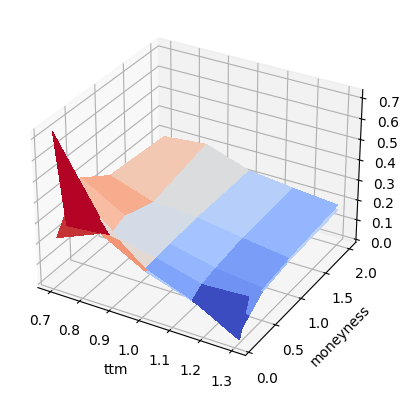

In [13]:
x = torch.from_numpy(data[9:11].reshape(1, 2, 5, 5)).float().to(model.device)
y = model(x)[0].detach().cpu().numpy().reshape((5,5))
plot_surface(data[10], y)

In [14]:
print(data[10])
print(y)

[[0.72464951 0.3797505  0.20524437 0.12131439 0.        ]
 [0.23808499 0.25893129 0.21339407 0.15409594 0.16549177]
 [0.41339477 0.29027929 0.21902075 0.16980012 0.14323103]
 [0.31220416 0.24044995 0.22961451 0.19413678 0.16450468]
 [0.28926708 0.3088492  0.23532392 0.20957814 0.18903915]]
[[0.21913455 0.3070672  0.18741314 0.11669292 0.03302307]
 [0.3082691  0.27306354 0.19373553 0.13704823 0.07225275]
 [0.30710438 0.257985   0.20509405 0.15599796 0.12630823]
 [0.28851825 0.24564692 0.20514798 0.17024218 0.14882538]
 [0.2512244  0.23929013 0.21090971 0.18380828 0.16388065]]
